### **CarND-Behavioral-Cloning-P3**
**Behavioral-Cloning**

This is the third project by me in the field of Deep Mchine learning as part of Udacity Nanodegree for Autonomous driving.

While the pervious project was on 'Logistic Classification' of the Deep Neural network model, this one is on the 'Regression' Supervised learning of the Deep Neural network.

The objective of this project(Behavioral Cloning) is to train a model to drive a car autonomously on a simulated track. The ability of the model to drive the car autonomously is learned from cloning the behaviour of a human driver. Training data is collected from examples of a human driving in the simulator provided by the Udacity, then fed into a deep learning network which learns the response (steering angle) for every encountered frame in the simulation. In other words, the model is trained to predict an appropriate steering angle for every frame while driving(hence Regression). The model is then validated on a new track to check for generalization of the learned features for performing steering angle prediction.

This project is influenced by nvidia paper, Udacity Lab sessions and vivek's blog which I reffered while working on my solution. The Keras Deep Learning library was used with Tensorflow backend, to perform deep learning operations.

**Behavioral Cloning Project Steps**

In Summary, the goals / steps of this project are the following:
* Use the simulator to collect data of good driving behavior
* Build, a convolution neural network in Keras that predicts steering angles from images
* Train and validate the model with a training and validation set
* Test that the model successfully drives around track one without leaving the road
* Summarize the results with a written report

### Data Recording

I can either use the data of steering angles and images provided by Udacity, or collect data ourselves by driving a car around a track in Udacity's simulator. 

Upon analysis of the sample data provided, the sample data has "Orginal Data Size: 8036". By ploting the graph on the streeing angle and # of images per streeing angle, we can see that there is more data with steering angle on the left.

![Data Histogram](images/DataHistogram.png)



This is true from the way the track is designed that the Track #1 is more heavy on the left turn than right.
So the data is not balanced equally. Also the # of sample data is not sufficient to train the model without under fitting or over fitting the model with just images from center camera and streeing angle.

Hence this has been solved by following the below methods i.e Collecting more data, preprocessing and data augumentation.

Data Collection:
In order to collect more data and more over balanced data, I drove the car in 'Training Mode' where we collect the data.
#1. I did around 2 laps of driving to supply enough images and corresponding steering angles to work with.
#2. 1 round of lap driving in the opposite direction (clockwise) to collect more data in order to negate the left baised track
#3. Drove the car to the edge of the track without recording and corrected back to the center of the road with recording enabled. This will train the model to correct the car or bring it back to the center of the road if it drifts off the road.

Once I had my own recorded data, I used the sample data for validation. This way I could use all the data I had collected to train the model and validate the model aganist the sample data provided.

Training Image:
![Training Image](images/Training.png)

Reverse Lap Training Image:
![Reverse Lap](images/ReverseDir.png)

Edge Recovery Image:
![Edge Correction](images/edgeCorrection.png)

Dirt Pit Recovery Image:
![Dirt Correction](images/DirtPitCorrection.png)

Corner/Curve Recovery Image:
![Corner Correction](images/cornercorrection.png)

Bridge Edge Recovery Image:
![Bridge Correction](images/BridgeEdgeCorrection.png)

Once I had the data captured, I loaded the data of around ~15K images from the csv file. The images are in three colums, snapped from center, right and left cameras. They have a corresponding steering angle -- the steer the car had to make in that frame to stay on the track. I loaded both into images[] and measurements[] arrays. 

Once I got the steering angles, I increased the value of the steering angle by 20% (multiplied by 1.2) to make the car more responsive. The main reason to do so was while training I went over the edges a few times, and corrected. I wanted the car to avoid those mistakes, so used higher gain on steering angle.

In [ ]:
# Load CSV File for Validation Data       
#Get Validation Data (This is Udacity provided same data)
Val_lines = []
with open('Val_DATA/driving_log.csv') as csvfile2 :
    reader = csv.reader(csvfile2)
    for line in reader :
        Val_lines.append(line)
        
Val_images = [] # Validation featuers
Val_measurments = [] # Validation labels

for line in Val_lines :
    #print(line[0])
    Val_source_path = line[0] # to get the center image file name/paths
    Val_file_name = Val_source_path.split('/')[-1]
    #print(file_name)
    Val_current_path = 'Val_DATA/IMG/'+Val_file_name
    Val_image = cv2.imread(Val_current_path)
    Val_images.append(Val_image)
    Val_measurment = float(line[3]) # to get the steering angle from the csv file
    Val_measurments.append(Val_measurment)
    
X_Val = np.array(Val_images)
y_Val = np.array(Val_measurments)

In [ ]:
Orginal Training Data Size: 14642
Orginal Validation Data Size: 8036

### Data processing

Data processing is done to allow the model to be able to easily work with raw data for training. In this project, I used a generator (keras fit_generator) to build the data processing as it allows for real-time processing of the data without consuming more memory or CPU. The advantage here is that, in the case that if we are working with a very large amount of data, the whole dataset is not loaded into memory at one shot, instead processed batch wise. We can therefore work with a manageable batch of data at a time. Hence the generator is run in parallel to the model, for efficiency. The generator is run in CPU per image, processed and sent to Keras model which is run on Tensorflow in GPU

The following processing steps were carried on the data:

*Randomly choose from center, left and right camera images:

The simulator provides three camera views namely; center, left and right views. Since I am going to use the generator which requires to use only one camera view per generator, I choose randomly from the three views. While using the left and right images, I did add and subtract 0.25 to the steering angles respectively to make up for the camera offsets (Tried with few other values, but felt 0.25 provided best results in terms of stability of the car).

*Randomly flip image:

In other to balance left and right images, I randomly flip images and change sign on the steering angles. The following figure shows the view from the left, right and center cameras after angles corrected. 

*Brightness Augmentation:

We simulate different brightness occasions by converting image to HSV channel and randomly scaling the V channel.

*Image Cropping: 

The top part of each image has all the trees and senery and bottom part has the car hood. These are not required for the model and may cause unnessary confusion while traning. Hence Cropped the top 60 pixels and bottom 20 pixels using the Keras Cropping function so as to feed the data that is required for the model to train and learn the behavior.



In [ ]:

#simulate different brightness occasions by converting image to HSV channel and randomly scaling the V channel.
def transform_brightness(image):
    """
    apply random brightness on the image
    """
    image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    
    # scaling up or down the V channel of HSV
    image[:,:,2] = image[:,:,2]*random_bright
    return image

## Data Augmuntation (Flip Images and steering angle)
augmented_images, augmented_angles = [], []
def data_augmuntation(images, angles):
    for image, angle in zip(images, angles):
        augmented_images.append(image)
        augmented_angles.append(angle)
        augmented_images.append(cv2.flip(image,1))
        augmented_angles.append(angle*-1.0)
    return augmented_images, augmented_angles

def data_flip(image, angle):
    augmented_images.append(image)
    augmented_angles.append(angle)
    # flip image (randomly)
    if np.random.randint(2) == 0: 
        augmented_images.append(cv2.flip(image,1))
        augmented_angles.append(angle*-1.0)
    return augmented_images, augmented_angles

# Load the data
images = [] # featuers
measurments = [] # labels

for line in lines :
    for i in range(3) :
        #print(line[0])
        source_path = line[i] # to get the center, right and left image file name/paths
        file_name = source_path.split('/')[-1]
        #print(file_name)
        current_path = 'Val_DATA/IMG/'+file_name
        image = cv2.imread(current_path)
        #image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = transform_brightness(image)
        images.append(image) # Images from Center, Left and Right camera are appended into 'images'
    correction = 0.20
    measurment = float(line[3]) # to get the steering angle from the csv file
    measurments.append(measurment) # Steering angle for Center Image
    measurments.append(measurment + correction) # Steering angle for Left Image
    measurments.append(measurment - correction) # Steering angle for Right Image
    
augmented_images, augmented_angles = data_augmuntation(images, measurments)
X_train = np.array(augmented_images)
y_train = np.array(augmented_angles)

### Model Training

I Selected Nvidia model for final training, because it gave better result after experimenting with other kinds of model (e.g. LeNet, simple models from Lab sessions etc). The Nvidia network consists of 9 layers,which has 5 convolutional layers and 4 fully connected layers Plus a normalization layer and Cropping of image. Converse to the Nvidia model, input image was split to HSV planes before been passed to the network.

Each of the layer is activitated by RELU activation.

Below is the reference for the Nvidia architecture guidence.

https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf

![Nvidia Arch](img/NvidiaArch.png)

Image was normalized in the first layer. According to the Nvidia paper, this enables normalization also to be accelerated via GPU processing.

Convolution are used in the first three layers with 2x2 strides and a 5x5 kernel, and non-strided convolution with 3x3 kernel size in the last two convolutional layers.

The convolutional layers are followed by three fully-connected layers which then outputs/predicts the steering angle.

Overfitting was reduced by using aggressive Dropout (0.3) on all the Convolution layers and L2 Regularization (0.001) on the first layer. This turned out to be a good practice as the model could generalize to the second track, without using it for training.

An Adam optimizer was used for optimization. This requires little or no tunning as the learning rate is adaptive. I run the training model for 3 Epochs as I could see that after it the loss is pretty much flat.

Though I had close to 15K sample training data, each epoch consisted of twice the samples (samples_per_epoch=len(train_samples)*2). This made the training more tractable, and since I was using a generator, all of the training data was still used in training, however at different epochs.

To conclude, self-recorded data was used for training, while the Udacity-provided samle data was used for validation during training.

In [ ]:
# Nvidia Model used for Behavioural Cloning Project
def nvidia_model(time_len=1):
    keep_prob = 0.3
    reg_val = 0.01
    model = Sequential()
    model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))
    model.add(Cropping2D(cropping=((60,20),(0,0)))) # Cropping the top 60 and bottom 20 pixels of the images
    model.add(Convolution2D(24,5,5,subsample=(2,2),activation='relu', W_regularizer=l2(reg_val)))
    model.add(Dropout(keep_prob))
    model.add(Convolution2D(36,5,5,subsample=(2,2),activation='relu'))
    model.add(Dropout(keep_prob))
    model.add(Convolution2D(48,5,5,subsample=(2,2),activation='relu'))
    model.add(Dropout(keep_prob))
    model.add(Convolution2D(64,3,3,activation='relu'))
    model.add(Dropout(keep_prob))
    model.add(Convolution2D(64,3,3,activation='relu'))
    model.add(Flatten())
    model.add(Dense(120))
    model.add(Activation('relu'))
    model.add(Dense(84))
    model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

### Training and validation

The Above Nvidia was the final model I selected to train the model. 

In [ ]:
# Select a Model
model = nvidia_model()
#model = Lenet_model()


history_object = model.fit_generator(train_generator, samples_per_epoch=len(train_samples)*2, validation_data=(X_Val, y_Val), nb_epoch=3)
model.save('model.h5')

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

I trained the model using the keras generator with batch size of 128 for 3 epochs. In each epoch, I generated len(train_samples)*2 images. The entire training took about 5 -7 minutes. However, it too more than few days of trial and error method to arrive at this architecture and training parameters. Snippet below presents the result of training.

Orginal Training Data Size: 6428
Orginal Validation Data Size: 1608
no_of_epochs=:Epoch 1/3 
50.21875
12821/12856 [============================>.] - ETA: 0s - loss: 0.0112   
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '
13017/12856 [==============================] - 69s - loss: 0.0112 - val_loss: 0.0180
Epoch 2/3
12910/12856 [==============================] - 64s - loss: 0.0053 - val_loss: 0.0193
Epoch 3/3
13052/12856 [==============================] - 55s - loss: 0.0047 - val_loss: 0.0211
dict_keys(['val_loss', 'loss'])


Once I had the best model that I thought will work, then I downloanded the saved mode (model.h5) to the local system to test it out on the simulator.


In [ ]:

scp carnd@54.1.1.1:/home/carnd/CarND-Behavioral-Cloning-P3/model.h5 .

Run the below commad to test the model and at the same time save the model o/p to a file to record the simulation.

In [ ]:
(carnd-term1) $ python drive.py model_Final_Nvida_Bri.h5 Final_Nvida_Bri

As expected, the car was able to drive and most part of the track #1, it was able to stay close to the center of the road. Once I had the car drive by itself on Track #1 for one full lap (Man was I happy..)exited out of the simulator and generated the video by using the below Udacity provided script - 

In [ ]:
(carnd-term1):CarND-Behavioral-Cloning-P3 vijaynaik$ python video.py Final_Nvida_Bri
Creating video Final_Nvida_Bri.mp4, FPS=60
[MoviePy] >>>> Building video Final_Nvida_Bri.mp4
[MoviePy] Writing video Final_Nvida_Bri.mp4
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5539/5539 [00:27<00:00, 199.58it/s]
[MoviePy] Done.
[MoviePy] >>>> Video ready: Final_Nvida_Bri.mp4

(carnd-term1) nss-admins-MacBook-Pro-6:CarND-Behavioral-Cloning-P3 vijaynaik$

All the required files, this report, images and scripts have been submited as part of project submission package.

### Conclusion

At first it looked simple and straight forward when I was doing all the lab session and thought would be able to complet it soon.

As I started exploring the data and started implementing all the required modules, it is then when it started getting complicated. I had to spend close to a week in trying to build various different types of models, trying various different hyper parameters.

At times it was fasturating as well to get the model work for just track #1 itself. I had to rebuild the models few times to understand the concept again and have all the right functions and hyper-paramters to finally get the model working. 

I am happy with the efforts on the track #1. Now my next challange is to get this going on track #2. Once I have track #2 solved, then generalize the model such that the same model works on both the tracks.

You can find the o/p of the Model o/p of Track #1 in the below links.

#1. Car Camera View Video:
https://youtu.be/joLZOyeKu1U

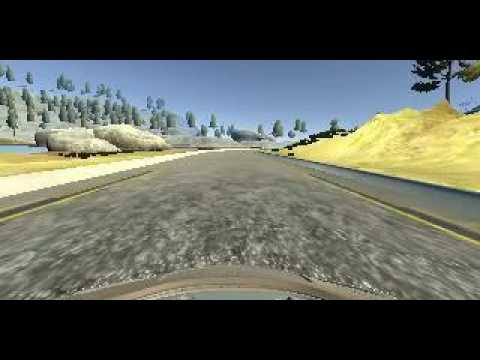

In [5]:
from IPython.display import YouTubeVideo
YouTubeVideo('joLZOyeKu1U')

#2. Complete Car View Vidoe:
https://youtu.be/uEzU61ZdIGA

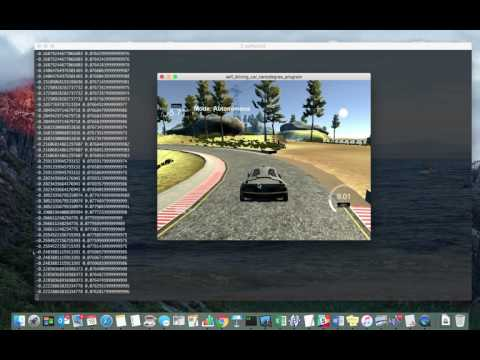

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo('uEzU61ZdIGA')

### Track2 (Challange Track)

Final after lots of efforts I was able to successfuly run the same Model on Track#2 as well. (Thanks to Luc Frachon - another student of Udacity for showing that predicted steering angel from the model can be further calibrated in run time as well. This was the majore single parameter change that made my Model work on Track#2.)

So all I had to do was calibrate the steering angel by multplying it to get the correct steering angle so the car stays inside the tracks.

Below parameter worked for my model. I multiplied the predicted Steering angle by 2.5 in the drive.py.

steering_angle = float(model.predict(image_array[None, :, :, :], batch_size=1))*2.5

Below are the Vidoe files showing the Model performance on the Track#2.

#1. Full Car View:
https://youtu.be/D117-ddNcpQ

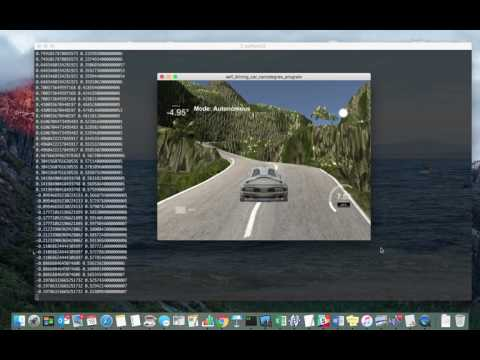

In [3]:
from IPython.display import YouTubeVideo
YouTubeVideo('D117-ddNcpQ')

#2. Car Camera View Vidoe: 
https://youtu.be/9IyZikbVlr4

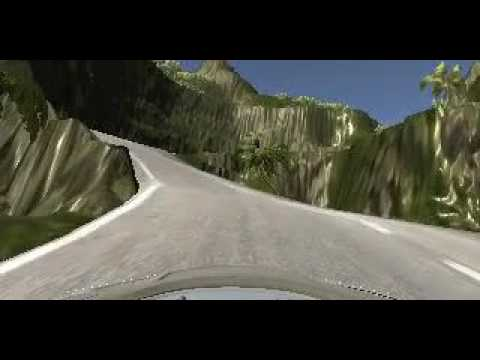

In [4]:
from IPython.display import YouTubeVideo
YouTubeVideo('9IyZikbVlr4')

### Files Included

Below are the list of files included in the project submission:
    1. train.ipynb - Main Model (containing the script to create and train the model)
    2. model_Final_Nvida_Bri.h5  -- containing a trained convolution neural network from train.ipynb
    3. drive.py - For driving the car in autonomous mode
    4. video.py - Used to create the simulation testing into vidoe file
    5. Final_Nvida_Bri.mp4 -- Vidoe of the simulation test run
    6. Behavioral Cloning-Report.ipynb -- Project Report (writeup_report summarizing the results).